# PCA Demonstration

## Create a synthetic surface matrix

We generate a matrix of IV surfaces where each row represents an asset and each column represents a strike (log-moneyness).

## Perform PCA

**Explained Variance:**
- PC1 explains **57.5%** of the variance
- PC2 explains **30.2%** of the variance
- PC3 explains **6.3%** of the variance
- The first 3 principal components together explain **94.0%** of the total variance
- The principal component loadings are plotted as well.


## Trading Use

**Relative-value (cross-sectional)**
- Compare PCA scores across assets
- Trade mispricings (e.g. skew too steep vs peers)

**Time-series strategies**
- Model PCA scores as state variables
- Trade mean reversion or regime shifts

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def create_iv_surface_matrix(
    n_stocks: int = 100,
    n_strikes: int = 50,
    noise_std: float = 0.01, 
    k_range: tuple[float, float] = (-0.3, 0.3),
    random_seed: int = 42, 
    level_mean: float = 0.2,
    level_mean_std: float = 0.02,
    level_std: float = 0.01,
    skew_mean: float = -0.15,  # Negative skew: OTM puts have higher vol
    skew_mean_std: float = 0.1,
    skew_std: float = 0.1,
    curvature_mean: float = 0.8,  # Positive curvature: U-shaped smile
    curvature_mean_std: float = 0.5,
    curvature_std: float = 0.25,
    fourth_mean: float = 0.3,
    fourth_mean_std: float = 0.2,
    fourth_std: float = 0.1,
) -> np.ndarray:

    # Set random seed
    np.random.seed(random_seed)
    
    # Create log-moneyness grid
    k = np.linspace(k_range[0], k_range[1], n_strikes)
    
    # Generate true basis functions
    level = np.ones(n_strikes)  # constant
    skew = k.copy()  # linear in k
    curvature = k**2  # quadratic in k
    fourth = k**4  # fourth-order term
    
    # Stack into basis matrix B: shape (n_strikes, 4)
    B = np.column_stack([level, skew, curvature, fourth])
    
    # Generate stock-specific means (each stock has slightly different mean)
    stock_level_means = np.random.normal(level_mean, level_mean_std, n_stocks)
    stock_skew_means = np.random.normal(skew_mean, skew_mean_std, n_stocks)
    stock_curvature_means = np.abs(np.random.normal(curvature_mean, curvature_mean_std, n_stocks))  # Keep positive
    stock_fourth_means = np.abs(np.random.normal(fourth_mean, fourth_mean_std, n_stocks))  # Keep positive
    
    # Generate random factor scores for each asset using stock-specific means
    # Ensure curvature is positive (smile shape) and skew is typically negative (volatility skew)
    a = np.random.normal(stock_level_means, level_std)  # level scores
    b = np.random.normal(stock_skew_means, skew_std)     # skew scores (negative = OTM puts higher vol)
    c = np.abs(np.random.normal(stock_curvature_means, curvature_std))  # curvature scores (always positive for smile)
    d = np.abs(np.random.normal(stock_fourth_means, fourth_std))  # fourth-order scores (always positive)
    
    # Stack into factor score matrix F: shape (n_stocks, 4)
    F = np.column_stack([a, b, c, d])
    
    # Construct surface matrix X: shape (n_stocks, n_strikes)
    X = F @ B.T
    
    # Ensure all IV values are positive (clip negative values to small positive)
    X = np.maximum(X, 0.05)  # Minimum IV of 5%
    
    # Add small Gaussian noise
    X += np.random.normal(0, noise_std, X.shape)
    
    # Ensure still positive after noise
    X = np.maximum(X, 0.05)
    
    return X

Surface matrix X shape: (100, 50)


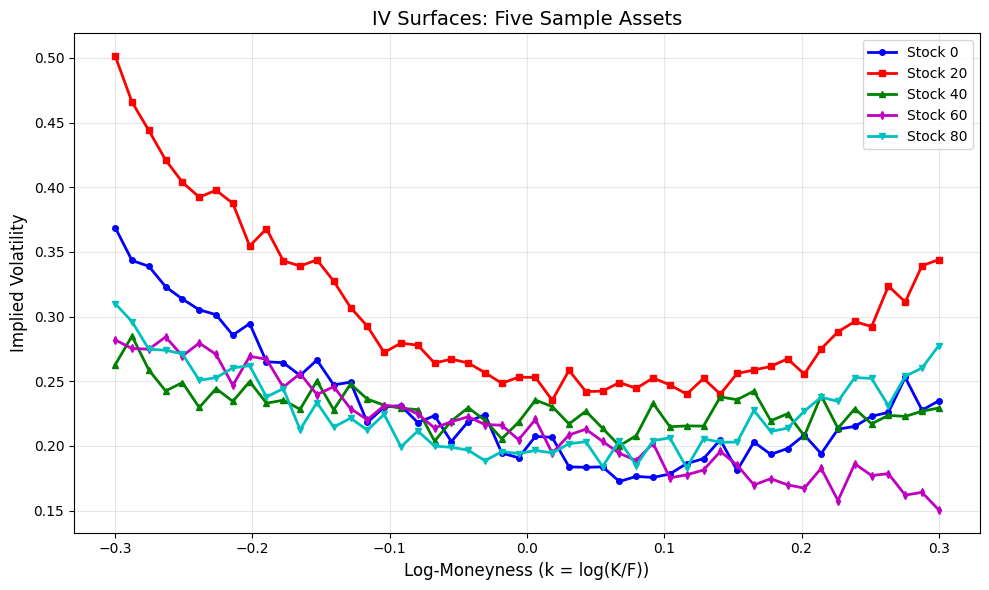

In [25]:
# Parameters
n_stocks = 100
n_strikes = 50

X = create_iv_surface_matrix(
    n_stocks=n_stocks,
    n_strikes=n_strikes
)
print(f"Surface matrix X shape: {X.shape}")

# Create strike array (log-moneyness k from -0.3 to 0.3)
k = np.linspace(-0.3, 0.3, n_strikes)

plt.figure(figsize=(10, 6))
# Plot five surfaces with different colors and styles
plt.plot(k, X[0], 'b-', linewidth=2, marker='o', markersize=4, label='Stock 0')
plt.plot(k, X[20], 'r-', linewidth=2, marker='s', markersize=4, label='Stock 20')
plt.plot(k, X[40], 'g-', linewidth=2, marker='^', markersize=4, label='Stock 40')
plt.plot(k, X[60], 'm-', linewidth=2, marker='d', markersize=4, label='Stock 60')
plt.plot(k, X[80], 'c-', linewidth=2, marker='v', markersize=4, label='Stock 80')
plt.xlabel('Log-Moneyness (k = log(K/F))', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.title('IV Surfaces: Five Sample Assets', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Perform PCA 
X_mean = np.mean(X, axis=0)  # Mean across assets (rows) for each strike (column)
X_centered = X - X_mean
U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Principal components (loadings): columns of Vt.T
PC_loadings = Vt.T

# Explained variance
explained_var = s**2 / (n_stocks - 1)
explained_var_ratio = explained_var / explained_var.sum()
cumulative_var = np.cumsum(explained_var_ratio)

print(f"Number of singular values: {len(s)}")
print(f"First 5 explained variance ratios: {explained_var_ratio[:5]}")
print(f"First 5 cumulative variance: {cumulative_var[:5]}")

Number of singular values: 50
First 5 explained variance ratios: [0.57535466 0.3023574  0.06275556 0.00344863 0.00321076]
First 5 cumulative variance: [0.57535466 0.87771206 0.94046762 0.94391625 0.94712701]


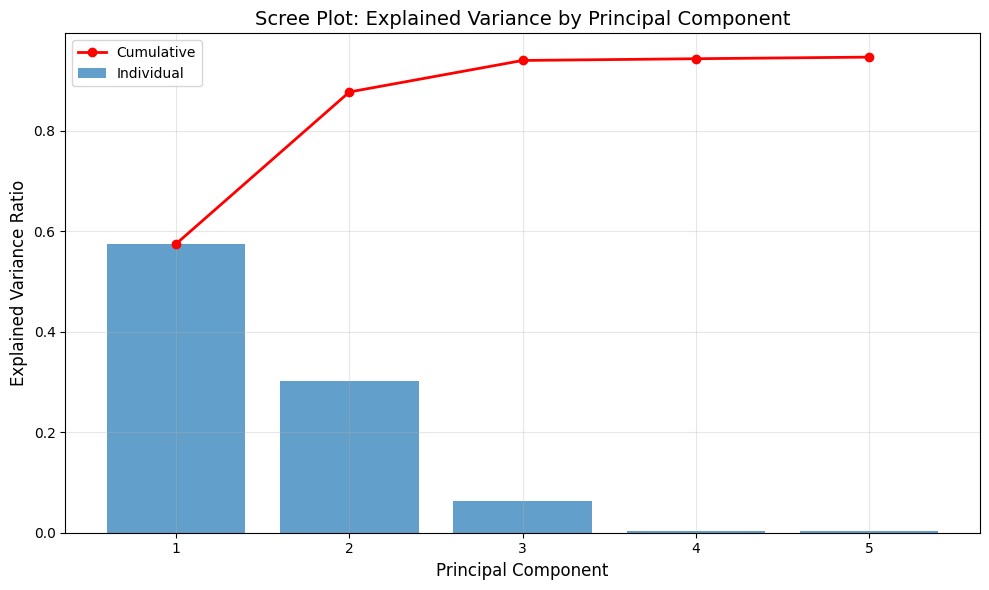

First 3 PCs explain 94.0% of variance


In [27]:
# Deliverable 1: Scree Plot
n_components_plot = min(5, len(s))
components = np.arange(1, n_components_plot + 1)

plt.figure(figsize=(10, 6))
plt.bar(components, explained_var_ratio[:n_components_plot], alpha=0.7, label='Individual')
plt.plot(components, cumulative_var[:n_components_plot], 'ro-', label='Cumulative', linewidth=2)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Scree Plot: Explained Variance by Principal Component', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(components)
plt.tight_layout()
plt.show()

print(f"First 3 PCs explain {cumulative_var[2]:.1%} of variance")

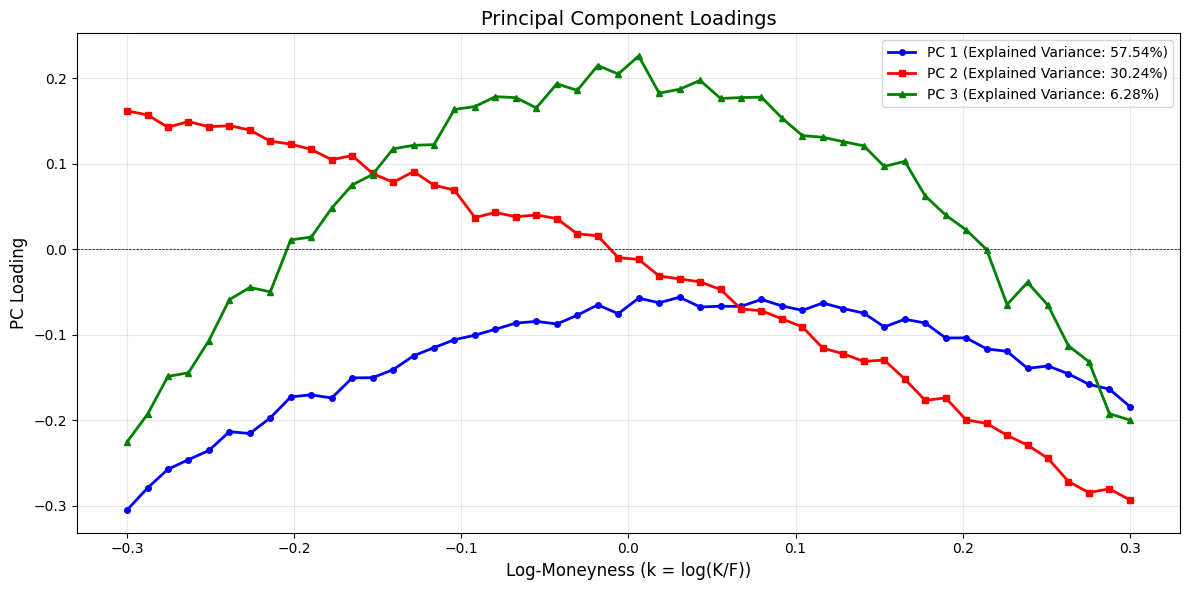

In [28]:
# Plot all three PCA components in one plot
n_components_to_plot = min(3, PC_loadings.shape[1])

plt.figure(figsize=(12, 6))

colors = ['b', 'r', 'g']
markers = ['o', 's', '^']

for i in range(n_components_to_plot):
    plt.plot(k, PC_loadings[:, i], linewidth=2, marker=markers[i], markersize=4, 
             color=colors[i], label=f'PC {i+1} (Explained Variance: {explained_var_ratio[i]:.2%})')

plt.xlabel('Log-Moneyness (k = log(K/F))', fontsize=12)
plt.ylabel('PC Loading', fontsize=12)
plt.title('Principal Component Loadings', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()